# computing contact areas

This example is based on test_smooth_system

In [1]:
import numpy as np
import pytest

from SurfaceTopography import make_sphere
from Adhesion.Interactions import Exponential, Lj82
from Adhesion.Interactions.cutoffs import LinearCorePotential
from ContactMechanics import (FreeFFTElasticHalfSpace)
from Adhesion.System import SmoothContactSystem, BoundedSmoothContactSystem

In [2]:
nx, ny = (64, 64)
sx, sy = [30] * 2
E_s = 5.
R = 10.
rho = 2.
w = 1.

surface = make_sphere(R, (nx, ny), (sx, sx), standoff=float('inf'))
# ext_surface = make_sphere(R, (2 * nx, 2 * ny), (2 * sx, 2 * sx),
#                          centre=(sx / 2, sx / 2), standoff=float('inf'))
smoothsystem = SmoothContactSystem(
    FreeFFTElasticHalfSpace((nx, ny), E_s, (sx, sx)),
    LinearCorePotential(Lj82(w, rho)), surface)

boundedsmoothsystem = BoundedSmoothContactSystem(
    FreeFFTElasticHalfSpace((nx, ny), E_s, (sx, sx)), Exponential(w, rho),
    surface)

penetration = 2.

sol = boundedsmoothsystem.minimize_proxy(
    penetration,
    options=dict(maxcor=3, ftol=0,
                 gtol=1e-6 * (
                         w / rho) * surface.area_per_pt),
    lbounds="auto")
assert sol.success
sol = smoothsystem.minimize_proxy(
    penetration - rho,
    options=dict(maxcor=3, ftol=0,
                 gtol=1e-6 * (w / rho) * surface.area_per_pt))
assert sol.success

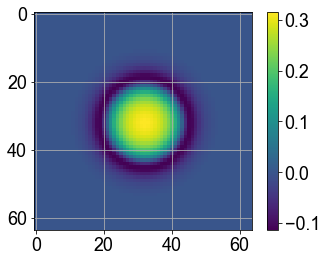

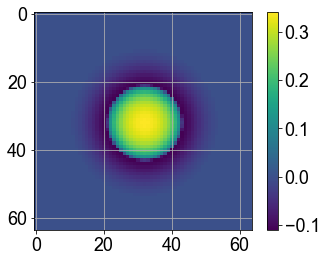

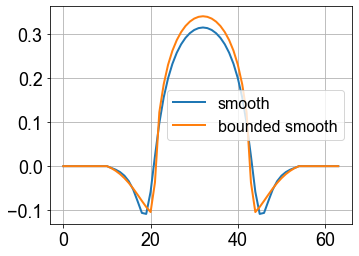

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# plt.colorbar(ax.contourf(
# - smoothsystem.substrate.force[
#       smoothsystem.substrate.topography_subdomain_slices],
#       levels=(-w/rho,-0.01,0.01,10.)), )
plt.colorbar(ax.imshow(- smoothsystem.substrate.force[
    smoothsystem.substrate.topography_subdomain_slices]))
plt.show()

fig, ax = plt.subplots()

plt.colorbar(ax.imshow(- boundedsmoothsystem.substrate.force[
    boundedsmoothsystem.substrate.topography_subdomain_slices]))

plt.show()

fig, ax = plt.subplots()
ax.plot(
    - smoothsystem.substrate.force[
          smoothsystem.substrate.topography_subdomain_slices]
    [:, ny // 2],
    label="smooth")
ax.plot(
    - boundedsmoothsystem.substrate.force[
          boundedsmoothsystem.substrate.topography_subdomain_slices]
    [:, ny // 2],
    label="bounded smooth")
ax.legend()
plt.show()

In [ ]:
np.testing.assert_allclose(boundedsmoothsystem.compute_nb_attractive_pts(),
                           smoothsystem.compute_nb_attractive_pts(),
                           rtol=0.1)
np.testing.assert_allclose(boundedsmoothsystem.compute_nb_repulsive_pts(),
                           smoothsystem.compute_nb_repulsive_pts(),
                           rtol=0.1)

np.testing.assert_allclose(boundedsmoothsystem.compute_normal_force(),
                           smoothsystem.compute_normal_force(), rtol=0.2)
np.testing.assert_allclose(boundedsmoothsystem.compute_repulsive_force(),
                           smoothsystem.compute_repulsive_force(),
                           rtol=0.2)
np.testing.assert_allclose(boundedsmoothsystem.compute_attractive_force(),
                           smoothsystem.compute_attractive_force(),
                           rtol=0.1)

The Bounded contact system has a very clear definition of contacting region

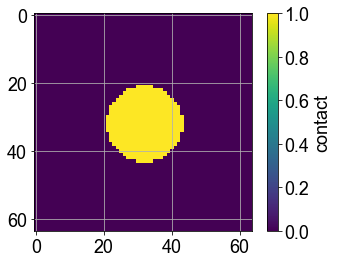

In [8]:
plt.colorbar(plt.imshow(boundedsmoothsystem.contact_zone.T), label="contact")

The definition of contact area in the smooth system that is the closest to this "JKR definition is the gap where the interaction is maximal"

In [11]:
gap_maxstress = smoothsystem.interaction.r_infl

In [15]:
smooth_contacting_zone = smoothsystem.gap < gap_maxstress

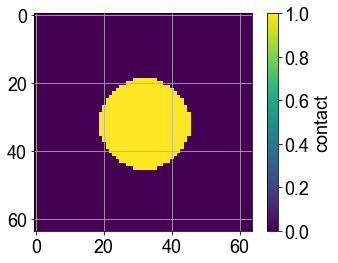

In [17]:
plt.colorbar(plt.imshow(smooth_contacting_zone.T), label="contact")

Here it is slightly larger